# SuperSet

In this notebook we aim to discover a way to represnet all of our finger prints

## Method 1:

aim is to clean up the data and add 2 new columns such as **Drug_name** and **bond_type** then i will input them in a 1D CNN and use XAI techniques to see why a model has made a specific prediction.


first we are going to clean up and change the format of the data

we are going to have the following:
* Residues 
* Interactions
* Frames


In [2]:
import pandas as pd
import os

# Define input config for each drug
drug_files = {
    "AMP": {
        "path": "Data/New/trained/fp_comp_dataframe_AMP.csv",
        "drug_name": "AMP",
        "bond_type": "inward"
    },

    # "BZT": {
    #     "path": "Data/New/fp_comp_dataframe_BZT.csv",
    #     "drug_name": "BZT",
    #     "bond_type": "outward"
    # },

    "COC": {
        "path": "Data/New/trained/fp_comp_dataframe_COC.csv",
        "drug_name": "COC",
        "bond_type": "outward"
    },

    "DOP": {
        "path": "Data/New/trained/fp_comp_dataframe_DOP.csv",
        "drug_name": "DOP",
        "bond_type": "occluded"

    },
    # "MAPB":{
    #     "path": "Data/New/fp_comp_dataframe_MAPB.csv",
    #     "drug_name": "MAPB",
    #     "bond_type": "inward"
    # },

    # "MPH":{
    #     "path": "Data/New/fp_comp_dataframe_MPH.csv",
    #     "drug_name": "MPH",
    #     "bond_type": "outward"
    # },

    # "Z78":{
    #     "path": "Data/New/fp_comp_dataframe_Z78.csv",
    #     "drug_name": "Z78",
    #     "bond_type": "outward"
    # },

    # "MDMA":{
    #     "path": "Data/Original/fp_comp_dataframe_MDMA.csv",
    #     "drug_name": "MDMA",
    #     "bond_type": "inward"
    # }
}

# Processing loop
for drug, config in drug_files.items():
    # Load original CSV
    df = pd.read_csv(config["path"])

    # STEP 1: Drop the third row (index 2), which contains mostly NaN values
    df_cleaned = df.drop(index=2).reset_index(drop=True)

    # STEP 2: Extract header rows
    header_residues = df_cleaned.iloc[0]
    header_types = df_cleaned.iloc[1]

    # STEP 3: Create MultiIndex
    multi_index = pd.MultiIndex.from_arrays([header_residues, header_types])

    # STEP 4: Drop header rows
    df_cleaned = df_cleaned.drop(index=[0, 1]).reset_index(drop=True)

    # STEP 5: Apply MultiIndex
    df_cleaned.columns = multi_index

    # STEP 6: Insert correct frame column
    frame_col = df.iloc[3:, 0].reset_index(drop=True)
    df_cleaned.insert(0, ("meta", "frame"), frame_col.astype(int))

    # STEP 6.5: Drop redundant ("protein", "interaction") column if present
    if ("protein", "interaction") in df_cleaned.columns:
        df_cleaned = df_cleaned.drop(columns=[("protein", "interaction")])

    # STEP 7: Convert numerics
    df_cleaned = df_cleaned.apply(pd.to_numeric, errors='ignore')

    # STEP 8: Fill NaN with 0
    df_cleaned = df_cleaned.fillna(0)

    # STEP 9: Add meta columns
    df_cleaned[("meta", "bond_type")] = config["bond_type"]
    df_cleaned[("meta", "drug_name")] = config["drug_name"]

    # STEP 10: Reorder columns
    df_cleaned = df_cleaned[
        [col for col in df_cleaned.columns if col[0] != "meta" or col[1] == "frame"] +
        [("meta", "bond_type"), ("meta", "drug_name")]
    ]

    # Save cleaned version
    output_path = f"Data/New/trained/clean/cleaned_{config['drug_name']}.csv"            #out directory
    df_cleaned.to_csv(output_path, index=False)
    print(f"Saved cleaned CSV for {drug}: {output_path}")


Saved cleaned CSV for AMP: Data/New/trained/clean/cleaned_AMP.csv
Saved cleaned CSV for COC: Data/New/trained/clean/cleaned_COC.csv
Saved cleaned CSV for DOP: Data/New/trained/clean/cleaned_DOP.csv


C:\Users\Amir\AppData\Local\Temp\ipykernel_18240\3182004071.py:85: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_cleaned = df_cleaned.apply(pd.to_numeric, errors='ignore')
C:\Users\Amir\AppData\Local\Temp\ipykernel_18240\3182004071.py:85: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_cleaned = df_cleaned.apply(pd.to_numeric, errors='ignore')
C:\Users\Amir\AppData\Local\Temp\ipykernel_18240\3182004071.py:85: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_cleaned = df_cleaned.apply(pd.to_numeric, errors='ignore')


### Numpy format 

loading the cleaned files, then extract:

* x = all numeric feature columns (residue fingerprints)
* y = bond_type label will be encoded such as 0= inward, 1= outward, 2= occluded

thnen converting them into NumPy arrays 
and stakcing them for model training.

**outcome:**

```
X shape: (1282, 46)
y shape: (1282,)
Classes: ['inward' 'outward']

```

In [43]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import os

# List of cleaned files to include
drug_files = ["AMP", "COC"]  # others can be added here

X_list = []
y_list = []

for drug in drug_files:
    # Load cleaned CSV
    df = pd.read_csv(f"Data/superset/approach_1/cleaned_{drug}.csv", header=[0, 1])

    # Extract feature matrix (drop all 'meta' columns)
    X = df.loc[:, df.columns.get_level_values(0) != "meta"]
    X = X.to_numpy(dtype=np.float32)

    # Extract and encode bond_type as target
    y = df[("meta", "bond_type")]
    y_list.append(y)

    # Append features
    X_list.append(X)

# Combine all drugs into a single dataset
X_all = np.vstack(X_list)

# Encode labels
le = LabelEncoder()
y_all = le.fit_transform(pd.concat(y_list).values)

# Shapes
print("X shape:", X_all.shape)
print("y shape:", y_all.shape)
print("Classes:", le.classes_)

# Save numpy arrays
output_dir = "Data/superset/approach_1/num"
os.makedirs(output_dir, exist_ok=True)

np.save(os.path.join(output_dir, "X_all.npy"), X_all)
np.save(os.path.join(output_dir, "y_all.npy"), y_all)
np.save(os.path.join(output_dir, "y_labels.npy"), le.classes_)

print(f"Saved NumPy arrays to: {output_dir}")


X shape: (1282, 46)
y shape: (1282,)
Classes: ['inward' 'outward']
Saved NumPy arrays to: Data/superset/approach_1/num


In [80]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# STEP 1: Load data
X = np.load("Data/superset/approach_1/num/X_all.npy")
y = np.load("Data/superset/approach_1/num/y_all.npy")
y_labels = np.load("Data/superset/approach_1/num/y_labels.npy", allow_pickle= True)

# STEP 2: Train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# STEP 3: PyTorch Dataset
class FingerprintDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx].unsqueeze(0), self.y[idx]  # shape: (1, features)

train_dataset = FingerprintDataset(X_train, y_train)
test_dataset = FingerprintDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# STEP 4: 1D CNN model
class CNN1D(nn.Module):
    def __init__(self, input_length, num_classes):
        super(CNN1D, self).__init__()
        self.net = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1),
            nn.Flatten(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# Instantiate model
input_length = X.shape[1]
num_classes = len(np.unique(y))
model = CNN1D(input_length, num_classes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# STEP 5: Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(50):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/50 - Loss: {total_loss:.4f}")

# STEP 6: Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y_batch.numpy())

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=y_labels))


Epoch 1/50 - Loss: 22.0506
Epoch 2/50 - Loss: 20.4114
Epoch 3/50 - Loss: 18.8914
Epoch 4/50 - Loss: 15.7279
Epoch 5/50 - Loss: 12.1657
Epoch 6/50 - Loss: 8.4809
Epoch 7/50 - Loss: 5.9380
Epoch 8/50 - Loss: 4.2279
Epoch 9/50 - Loss: 2.9953
Epoch 10/50 - Loss: 2.2395
Epoch 11/50 - Loss: 1.7513
Epoch 12/50 - Loss: 1.3162
Epoch 13/50 - Loss: 1.0971
Epoch 14/50 - Loss: 0.9170
Epoch 15/50 - Loss: 0.7867
Epoch 16/50 - Loss: 0.6872
Epoch 17/50 - Loss: 0.6075
Epoch 18/50 - Loss: 0.5417
Epoch 19/50 - Loss: 0.4916
Epoch 20/50 - Loss: 0.4469
Epoch 21/50 - Loss: 0.4061
Epoch 22/50 - Loss: 0.3606
Epoch 23/50 - Loss: 0.3304
Epoch 24/50 - Loss: 0.3006
Epoch 25/50 - Loss: 0.2950
Epoch 26/50 - Loss: 0.2593
Epoch 27/50 - Loss: 0.2448
Epoch 28/50 - Loss: 0.2187
Epoch 29/50 - Loss: 0.2014
Epoch 30/50 - Loss: 0.1914
Epoch 31/50 - Loss: 0.1787
Epoch 32/50 - Loss: 0.1687
Epoch 33/50 - Loss: 0.1641
Epoch 34/50 - Loss: 0.1643
Epoch 35/50 - Loss: 0.1542
Epoch 36/50 - Loss: 0.1332
Epoch 37/50 - Loss: 0.1277
Epoch

In [81]:
# Directory to save model weights
import os
os.makedirs("Data/superset/approach_1/model", exist_ok=True)

# Save model weights (state_dict)
model_path = "Data/superset/approach_1/model/cnn1d_weights.pth"
torch.save(model.state_dict(), model_path)

print(f"Model weights saved to: {model_path}")


Model weights saved to: Data/superset/approach_1/model/cnn1d_weights.pth


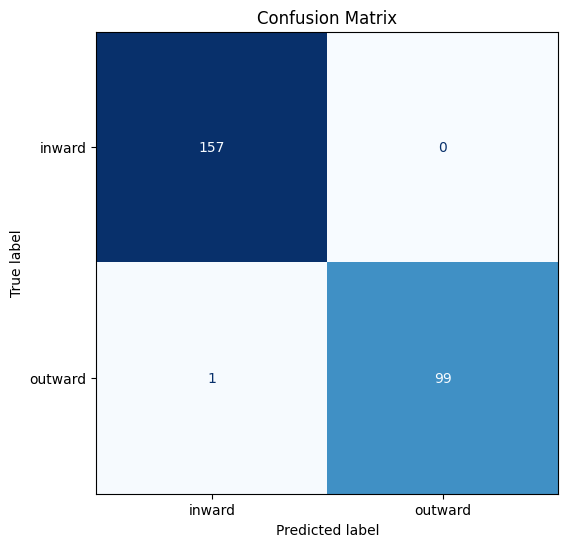

Classification Report:
              precision    recall  f1-score   support

      inward       0.99      1.00      1.00       157
     outward       1.00      0.99      0.99       100

    accuracy                           1.00       257
   macro avg       1.00      0.99      1.00       257
weighted avg       1.00      1.00      1.00       257



In [83]:
#Model Diagnostic 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# STEP 1: Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_labels)

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.title("Confusion Matrix")
plt.show()

# STEP 2: Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=y_labels))


### Making predictions!

now the aim is to load and clean a new data that the model hasn't seen before, then use the the saved model weights to make predictions. the dtug that i will be using is **MDMA** 

In [84]:
# Load cleaned MDMA CSV
df = pd.read_csv("Data/superset/approach_1/cleaned_MDMA.csv", header=[0, 1])
X_mdma = df.loc[:, df.columns.get_level_values(0) != "meta"].to_numpy(dtype=np.float32)
X_mdma_tensor = torch.tensor(X_mdma).unsqueeze(1)  # shape: (n_samples, 1, features)

# Load model and weights
model = CNN1D(input_length=X_mdma.shape[1], num_classes=2) # need to chaneg to 3 if we have Occluded
model.load_state_dict(torch.load("Data/superset/approach_1/model/cnn1d_weights.pth"))
model.eval()

# Predict
with torch.no_grad():
    outputs = model(X_mdma_tensor)
    preds = torch.argmax(outputs, dim=1)


In [85]:
# Count predictions per class
import numpy as np
unique, counts = np.unique(preds.numpy(), return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {cls} → {count} frames predicted")


Class 0 → 578 frames predicted
Class 1 → 163 frames predicted


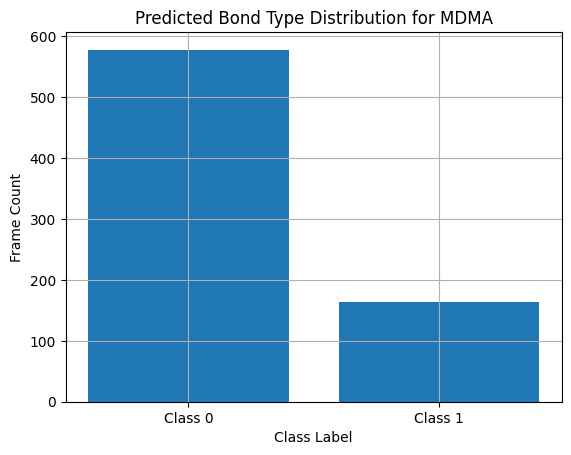

In [86]:
import matplotlib.pyplot as plt

# Convert to counts
plt.bar(unique, counts, tick_label=[f"Class {i}" for i in unique])
plt.title("Predicted Bond Type Distribution for MDMA")
plt.xlabel("Class Label")
plt.ylabel("Frame Count")
plt.grid(True)
plt.show()


In [87]:
label_names = ['inward', 'outward']  # order must match training label encoding
for cls, count in zip(unique, counts):
    print(f"{label_names[cls]}: {count} frames")


inward: 578 frames
outward: 163 frames


### Why model predicted inward and outward?

now it's time to use XAI techniques such as Lime and Shap to undrestand models predictions

* LIME: re-assesses the models input features and checks model response to identify most influential residues
* SHAP: computes score of each attribution per prediction

In [78]:
from lime import lime_tabular
import pandas as pd
import torch
import numpy as np

# Load cleaned AMP (training reference) CSV to get consistent feature names
df_train = pd.read_csv("Data/superset/approach_1/cleaned_AMP.csv", header=[0, 1])
real_feature_names = [f"{a} ({b})" for a, b in df_train.columns if a != "meta"]

# Check shape to avoid IndexError
assert X_all.shape[1] == len(real_feature_names), "Feature count mismatch in X_all"
assert X_mdma.shape[1] == len(real_feature_names), "Feature count mismatch in X_mdma"

# LIME explainer
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_all,
    feature_names=real_feature_names,
    class_names=['inward', 'outward'],  # Only these two were trained
    discretize_continuous=True
)

# Wrapper for prediction
def predict_proba_fn(x):
    x_tensor = torch.tensor(x).unsqueeze(1).float()  # (batch, 1, features)
    with torch.no_grad():
        logits = model(x_tensor)
        probs = torch.softmax(logits, dim=1)
    return probs.cpu().numpy()


AssertionError: Feature count mismatch in X_mdma

In [77]:
# Choose an index from MDMA
i = 42
explanation = explainer.explain_instance(X_mdma[i].ravel(), predict_proba_fn)
explanation.show_in_notebook()

IndexError: index 44 is out of bounds for axis 0 with size 44

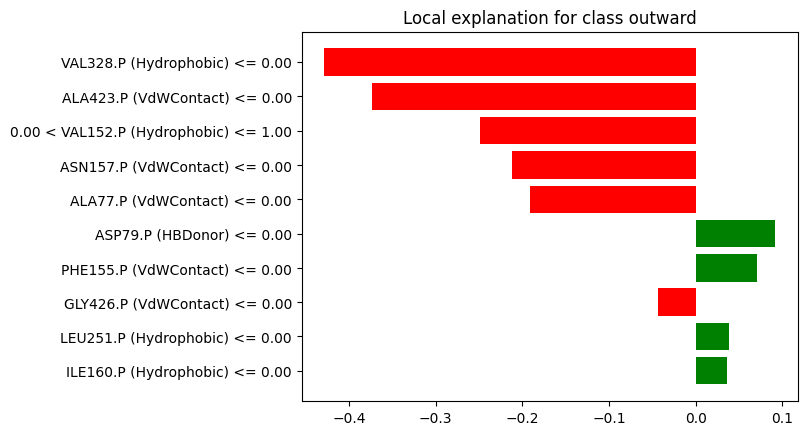

In [73]:
fig = explanation.as_pyplot_figure()
fig.patch.set_facecolor('white')  
plt.show()


### SHAP

In [79]:
import shap
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load cleaned training CSV to get correct feature names
df_train = pd.read_csv("Data/superset/approach_1/cleaned_AMP.csv", header=[0, 1])
real_feature_names = [f"{a} ({b})" for a, b in df_train.columns if a != "meta"]

# Prepare background from training data
background = torch.tensor(X_all[:200]).unsqueeze(1).float()  # (100, 1, features)

# Prepare MDMA sample(s) to explain
mdma_tensor = torch.tensor(X_mdma).unsqueeze(1).float()  # (n_samples, 1, features)

# Ensure model is in eval mode
model.eval()

# Create SHAP DeepExplainer with PyTorch model
explainer = shap.DeepExplainer(model, background)

# Pick a frame index from MDMA to explain
i = 42  # or any frame index
shap_values = explainer.shap_values(mdma_tensor[i:i+1], check_additivity=False)

# Get predicted class index
pred_class = torch.argmax(model(mdma_tensor[i:i+1])).item()

# Flatten SHAP values if needed (e.g. shape is (44, 2))
shap_vector = shap_values[pred_class][0]
if shap_vector.ndim == 2 and shap_vector.shape[1] == 2:
    shap_vector = shap_vector.sum(axis=1)

# Create a SHAP Explanation object
explanation_obj = shap.Explanation(
    values=shap_vector,
    base_values=explainer.expected_value[pred_class],
    data=X_mdma[i],
    feature_names=real_feature_names
)

# Modern SHAP plot (clean, readable)
shap.plots.waterfall(explanation_obj)


RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 44 but got size 46 for tensor number 1 in the list.

## Method 2: Transfer learning!

we will be using a **ResNet1D**, why? 

* proven performance on sequential fingerprint like data
* compatible with SHAP and LIME
* can be easily pre-trained or extended

**note**: use the pre-processing steps in **Method 1**

### pre-processing FOR PREDICTION ONLY 

In [15]:
import pandas as pd
import os

# List of input file paths (just paths, no extra metadata)
input_files = [
    "Data/New/fp_comp_dataframe_BZT.csv",
    "Data/New/fp_comp_dataframe_MAPB.csv", 
    "Data/New/fp_comp_dataframe_MPH.csv",
    "Data/Original/fp_comp_dataframe_MDMA.csv"
]

# Output directory
output_dir = "Data/New/processed"
os.makedirs(output_dir, exist_ok=True)

for file_path in input_files:
    # Load original CSV
    df = pd.read_csv(file_path)

    # STEP 1: Drop the third row (index 2), which contains mostly NaN values
    df_cleaned = df.drop(index=2).reset_index(drop=True)

    # STEP 2: Extract header rows
    header_residues = df_cleaned.iloc[0]
    header_types = df_cleaned.iloc[1]

    # STEP 3: Create MultiIndex
    multi_index = pd.MultiIndex.from_arrays([header_residues, header_types])

    # STEP 4: Drop header rows
    df_cleaned = df_cleaned.drop(index=[0, 1]).reset_index(drop=True)

    # STEP 5: Apply MultiIndex
    df_cleaned.columns = multi_index

    # STEP 6: Insert correct frame column
    frame_col = df.iloc[3:, 0].reset_index(drop=True)
    df_cleaned.insert(0, ("meta", "frame"), frame_col.astype(int))

    # STEP 6.5: Drop redundant ("protein", "interaction") column if present
    if ("protein", "interaction") in df_cleaned.columns:
        df_cleaned = df_cleaned.drop(columns=[("protein", "interaction")])

    # STEP 7: Convert numerics
    df_cleaned = df_cleaned.apply(pd.to_numeric, errors='ignore')

    # STEP 8: Fill NaN with 0
    df_cleaned = df_cleaned.fillna(0)

    # Save cleaned version
    base_name = os.path.basename(file_path)
    output_path = os.path.join(output_dir, f"cleaned_{base_name}")
    df_cleaned.to_csv(output_path, index=False)

    print(f"Saved cleaned CSV: {output_path}")


Saved cleaned CSV: Data/New/processed\cleaned_fp_comp_dataframe_BZT.csv
Saved cleaned CSV: Data/New/processed\cleaned_fp_comp_dataframe_MAPB.csv
Saved cleaned CSV: Data/New/processed\cleaned_fp_comp_dataframe_MPH.csv
Saved cleaned CSV: Data/New/processed\cleaned_fp_comp_dataframe_MDMA.csv


C:\Users\Amir\AppData\Local\Temp\ipykernel_18240\3133980763.py:45: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_cleaned = df_cleaned.apply(pd.to_numeric, errors='ignore')
C:\Users\Amir\AppData\Local\Temp\ipykernel_18240\3133980763.py:45: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_cleaned = df_cleaned.apply(pd.to_numeric, errors='ignore')
C:\Users\Amir\AppData\Local\Temp\ipykernel_18240\3133980763.py:45: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_cleaned = df_cleaned.apply(pd.to_numeric, errors='ignore')
C:\Users\Amir\AppData\Local\Temp\ipykernel_18240\3133980763.py:45: FutureWarning: errors='ignore' is deprecated and will rai

### Feature Selection

In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Set paths
input_dir = "Data/New/trained/clean"
output_dir = "models/v2"
os.makedirs(output_dir, exist_ok=True)

# Step 1: Get full feature column set
all_columns = set()
meta_cols = [("meta", "frame"), ("meta", "bond_type"), ("meta", "drug_name")]

for file in os.listdir(input_dir):
    if file.endswith(".csv"):
        df = pd.read_csv(os.path.join(input_dir, file), header=[0, 1])
        feature_cols = [col for col in df.columns if col[0] != "meta"]
        all_columns.update(feature_cols)

# Sort and freeze final feature order
all_columns = sorted(all_columns)
final_columns = all_columns  # Only features

# Step 2: Process all files
X_list, y_list, drug_names = [], [], []

for file in os.listdir(input_dir):
    if file.endswith(".csv"):
        df = pd.read_csv(os.path.join(input_dir, file), header=[0, 1])
        drug = df[("meta", "drug_name")].values[0] if ("meta", "drug_name") in df.columns else "unknown"
        y = df[("meta", "bond_type")].values

        # Align features to global set, fill missing with 0
        df_features = df.reindex(columns=final_columns, fill_value=0)
        X = df_features.to_numpy(dtype=np.float32)

        X_list.append(X)
        y_list.append(y)
        drug_names.extend([drug] * len(y))

# Stack
X_all = np.vstack(X_list)
y_all_series = np.concatenate(y_list)

# Encode labels
le = LabelEncoder()
y_all = le.fit_transform(y_all_series)
y_labels = le.classes_

# Show class counts
print("Original class distribution:", Counter(y_all))

# Undersample
rus = RandomUnderSampler(random_state=42)
X_balanced, y_balanced = rus.fit_resample(X_all, y_all)
print("Balanced class distribution:", Counter(y_balanced))

# Save
np.save(os.path.join(output_dir, "X_all.npy"), X_balanced)
np.save(os.path.join(output_dir, "y_all.npy"), y_balanced)
np.save(os.path.join(output_dir, "y_labels.npy"), y_labels)
np.save(os.path.join(output_dir, "feature_names.npy"), np.array(final_columns, dtype=object))

print("✅ Saved aligned & balanced dataset to:", output_dir)


Original class distribution: Counter({np.int64(1): 3287, np.int64(2): 2879, np.int64(0): 781})
Balanced class distribution: Counter({np.int64(0): 781, np.int64(1): 781, np.int64(2): 781})
✅ Saved aligned & balanced dataset to: models/v2


### Model architecture  

#### initial one  

In [ ]:

# class ResidualBlock1D(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel_size=3):
#         super(ResidualBlock1D, self).__init__()
#         self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=1)
#         self.bn1 = nn.BatchNorm1d(out_channels)
#         self.relu = nn.ReLU()
#         self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=1)
#         self.bn2 = nn.BatchNorm1d(out_channels)

#         self.downsample = nn.Sequential()
#         if in_channels != out_channels:
#             self.downsample = nn.Conv1d(in_channels, out_channels, 1)

#     def forward(self, x):
#         identity = self.downsample(x)
#         out = self.relu(self.bn1(self.conv1(x)))
#         out = self.bn2(self.conv2(out))
#         out = out + identity
#         return self.relu(out)

# class ResNet1D(nn.Module):
#     def __init__(self, input_channels, num_classes):
#         super(ResNet1D, self).__init__()
#         self.layer1 = ResidualBlock1D(input_channels, 32)
#         self.layer2 = ResidualBlock1D(32, 64)
#         self.pool = nn.AdaptiveAvgPool1d(1)
#         self.flatten = nn.Flatten()
#         self.fc = nn.Linear(64, num_classes)

#     def forward(self, x):
#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.pool(x)
#         x = self.flatten(x)
#         return self.fc(x)


#### Modified one

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, downsample=None, dropout=0.2):
        super(ResidualBlock1D, self).__init__()
        padding = kernel_size // 2
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, padding=padding)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=padding)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        return self.relu(out)

class ExpandedResNet1D(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(ExpandedResNet1D, self).__init__()
        
        self.initial_conv = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        )
        
        # Residual layers with increasing channels
        self.layer1 = self._make_layer(64, 64, blocks=3)
        self.layer2 = self._make_layer(64, 128, blocks=4, stride=2)
        self.layer3 = self._make_layer(128, 256, blocks=6, stride=2)
        self.layer4 = self._make_layer(256, 512, blocks=3, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm1d(out_channels)
            )
        layers = []
        layers.append(ResidualBlock1D(in_channels, out_channels, stride=stride, downsample=downsample))
        for _ in range(1, blocks):
            layers.append(ResidualBlock1D(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.initial_conv(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        return self.fc(x)

### Loading the data

In [59]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

# Load files
X = np.load("models/v2/X_all.npy")
y = np.load("models/v2/y_all.npy")
y_labels = np.load("models/v2/y_labels.npy", allow_pickle=True)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train).unsqueeze(1).float()
y_train_tensor = torch.tensor(y_train).long()
X_test_tensor = torch.tensor(X_test).unsqueeze(1).float()
y_test_tensor = torch.tensor(y_test).long()

# Dataloaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64)


### Model training 

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate your expanded ResNet model
model = ExpandedResNet1D(input_channels=1, num_classes=len(y_labels)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop with basic progress info
for epoch in range(50):
    model.train()
    running_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/50 - Loss: {avg_loss:.4f}")


Epoch 1/50 - Loss: 0.2260
Epoch 2/50 - Loss: 0.0340
Epoch 3/50 - Loss: 0.0205
Epoch 4/50 - Loss: 0.0133
Epoch 5/50 - Loss: 0.0081
Epoch 6/50 - Loss: 0.0051
Epoch 7/50 - Loss: 0.0061
Epoch 8/50 - Loss: 0.0096
Epoch 9/50 - Loss: 0.0082
Epoch 10/50 - Loss: 0.0075
Epoch 11/50 - Loss: 0.0045
Epoch 12/50 - Loss: 0.0071
Epoch 13/50 - Loss: 0.0057
Epoch 14/50 - Loss: 0.0013
Epoch 15/50 - Loss: 0.0004
Epoch 16/50 - Loss: 0.0122
Epoch 17/50 - Loss: 0.0113
Epoch 18/50 - Loss: 0.0119
Epoch 19/50 - Loss: 0.0090
Epoch 20/50 - Loss: 0.0130
Epoch 21/50 - Loss: 0.0076
Epoch 22/50 - Loss: 0.0062
Epoch 23/50 - Loss: 0.0021
Epoch 24/50 - Loss: 0.0091
Epoch 25/50 - Loss: 0.0008
Epoch 26/50 - Loss: 0.0004
Epoch 27/50 - Loss: 0.0001
Epoch 28/50 - Loss: 0.0002
Epoch 29/50 - Loss: 0.0000
Epoch 30/50 - Loss: 0.0001
Epoch 31/50 - Loss: 0.0014
Epoch 32/50 - Loss: 0.0003
Epoch 33/50 - Loss: 0.0034
Epoch 34/50 - Loss: 0.0059
Epoch 35/50 - Loss: 0.0036
Epoch 36/50 - Loss: 0.0073
Epoch 37/50 - Loss: 0.0007
Epoch 38/5

### Eval 

In [9]:
from sklearn.metrics import classification_report

model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        preds = torch.argmax(model(X_batch), dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_true.extend(y_batch.numpy())

print(classification_report(all_true, all_preds, target_names=y_labels))


              precision    recall  f1-score   support

      inward       0.99      1.00      1.00       156
    occluded       1.00      1.00      1.00       156
     outward       1.00      0.99      1.00       157

    accuracy                           1.00       469
   macro avg       1.00      1.00      1.00       469
weighted avg       1.00      1.00      1.00       469



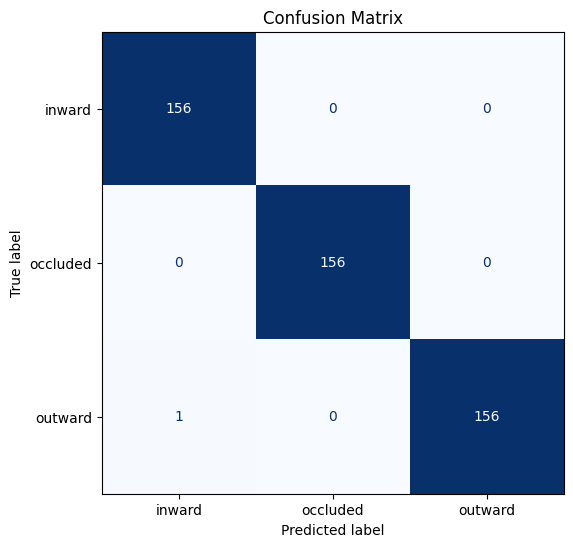

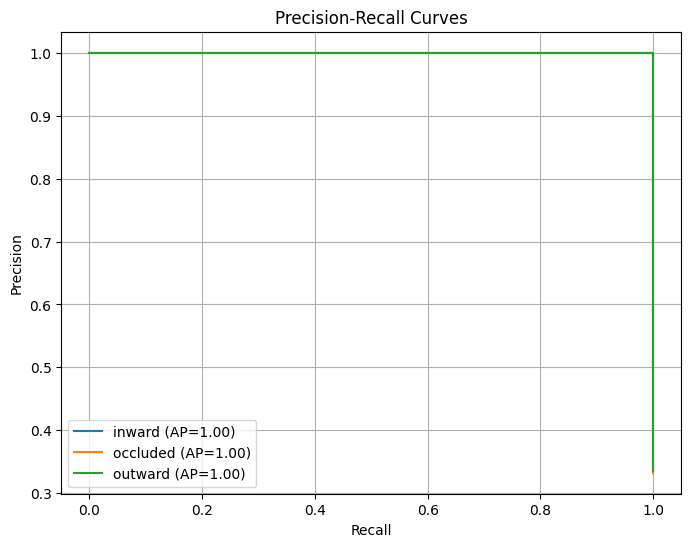

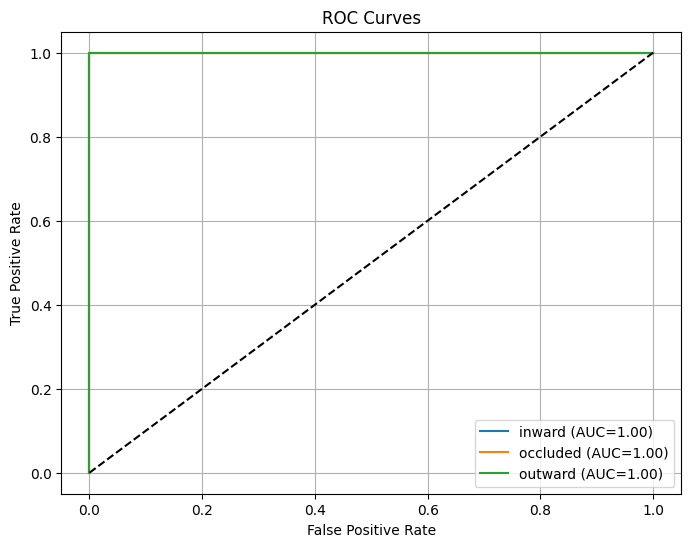

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Confusion Matrix
cm = confusion_matrix(all_true, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_labels)
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.title("Confusion Matrix")
plt.show()

# Precision-Recall Curve (one-vs-rest for multi-class)
y_true_bin = label_binarize(all_true, classes=range(len(y_labels)))
y_pred_scores = np.zeros((len(all_preds), len(y_labels)))  # placeholder for predicted probabilities

# You need model outputs (softmax probabilities) for this, so here is an example on how to get it:

model.eval()
probs_list = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        probs_list.append(probs)
y_pred_scores = np.vstack(probs_list)

plt.figure(figsize=(8,6))
for i, label in enumerate(y_labels):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_scores[:, i])
    avg_prec = average_precision_score(y_true_bin[:, i], y_pred_scores[:, i])
    plt.plot(recall, precision, label=f"{label} (AP={avg_prec:.2f})")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# ROC Curve and AUC
plt.figure(figsize=(8,6))
for i, label in enumerate(y_labels):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC={roc_auc:.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='best')
plt.grid(True)
plt.show()


### Saving the trained model  

In [10]:
torch.save(model.state_dict(), "models/v2/v2_model.pt")
print("Model saved to models/v2/v2_model.pt")


Model saved to models/v2/v2_model.pt


### Lime model

In [13]:
import lime
from lime.lime_tabular import LimeTabularExplainer
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# per frame explanations
frame_index = 20 

# === Step 2: Prepare training data ===
X_lime = X_test  # Use full aligned test set
feature_names_lime = [f"{res}-{inter}" for res, inter in feature_names]

# === Step 3: Setup LIME explainer ===
explainer = LimeTabularExplainer(
    training_data=X_lime,
    mode="classification",
    class_names=y_labels.tolist(),
    feature_names=feature_names_lime,
    discretize_continuous=False
)

# === Step 4: Define model prediction function for LIME ===
def predict_fn_lime(inputs):
    inputs_tensor = torch.tensor(inputs[:, np.newaxis, :], dtype=torch.float32).to(device)
    outputs = model(inputs_tensor)
    probs = F.softmax(outputs, dim=1).detach().cpu().numpy()
    return probs

# === Step 5: Explain one instance ===
explanation = explainer.explain_instance(
    data_row=X_lime[frame_index],
    predict_fn=predict_fn_lime,
    num_features=12,
    top_labels=1
)

# === Step 6: Manually show explanation with green/orange styling ===
html = explanation.as_html(show_table=True)
display(HTML(html))


### SHAP

In [14]:
import shap
import torch
import numpy as np

# === Step 1: Select frame to explain ===
frame_index = 500  # Change to test other frames

# === Step 2: Prepare background and test sample ===
background = torch.tensor(X_test[:200]).unsqueeze(1).float().to(device)  # Use 200 samples as SHAP background
test_sample = torch.tensor(X_test[frame_index:frame_index+1]).unsqueeze(1).float().to(device)

# === Step 3: Build SHAP explainer ===
explainer = shap.DeepExplainer(model, background)

# === Step 4: Predict class and confidence ===
with torch.no_grad():
    output = model(test_sample)
    probs = torch.softmax(output, dim=1).cpu().numpy()[0]
    pred_class = np.argmax(probs)
    pred_label = y_labels[pred_class]
    confidence = probs[pred_class]

print(f"\n🧠 Prediction for Frame {frame_index}: {pred_label.upper()} (Confidence: {confidence:.2f})")

# === Step 5: Compute SHAP values for selected class ===
shap_values = explainer.shap_values(test_sample, check_additivity=False)
shap_vector = shap_values[0][0, :, pred_class]
base_value = explainer.expected_value[pred_class]

# === Step 6: Create SHAP Explanation object ===
explanation = shap.Explanation(
    values=shap_vector,
    base_values=base_value,
    data=X_test[frame_index],
    feature_names=[f"{res}-{inter}" for res, inter in feature_names]
)

# === Step 7: Plot waterfall chart ===
shap.plots.waterfall(explanation, max_display=20)  # Show top 20 features


d:\Coding Projects\AI-in-Drug-Discovery-\god\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


IndexError: index 0 is out of bounds for axis 0 with size 0

## Method 3: Model improvements  


- **Balanced Sampling:** Introduced `WeightedRandomSampler` to handle class imbalance during training.
- **Regularisation:** Applied `weight_decay` in the optimizer to reduce overfitting via L2 regularisation.
- **Validation Split:** Added a validation set to monitor generalisation and prevent overfitting.
- **Early Stopping:** Implemented early stopping based on validation loss to avoid over-training.
- **Learning Rate Scheduling:** Used `ReduceLROnPlateau` to dynamically adjust learning rate when performance plateaus.



In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tqdm import tqdm

### Model Definition 

In [34]:
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, downsample=None, dropout=0.2):
        super(ResidualBlock1D, self).__init__()
        padding = kernel_size // 2
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, padding=padding)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=padding)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        return self.relu(out)

class ExpandedResNet1D(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(ExpandedResNet1D, self).__init__()
        self.initial_conv = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        )
        self.layer1 = self._make_layer(64, 64, blocks=3)
        self.layer2 = self._make_layer(64, 128, blocks=4, stride=2)
        self.layer3 = self._make_layer(128, 256, blocks=6, stride=2)
        self.layer4 = self._make_layer(256, 512, blocks=3, stride=2)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm1d(out_channels)
            )
        layers = [ResidualBlock1D(in_channels, out_channels, stride=stride, downsample=downsample)]
        for _ in range(1, blocks):
            layers.append(ResidualBlock1D(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial_conv(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        return self.fc(x)


### Load & stack up

In [44]:
# 📂 Load full dataset from your saved NumPy arrays
import numpy as np

X_all = np.load("models/v2/X_all.npy")       # shape (n_samples, n_features)
y_all = np.load("models/v2/y_all.npy")       # integer labels 0,1,2
y_labels = np.load("models/v2/y_labels.npy", allow_pickle=True)  # class names

# Convert to PyTorch tensors
import torch
X_all_tensor = torch.tensor(X_all).unsqueeze(1).float()
y_all_tensor = torch.tensor(y_all).long()

### train/test Split & Weighted Sampler

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
import numpy as np

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, stratify=y_all, random_state=42
)

# Convert to tensors
X_train_tensor = torch.tensor(X_train).unsqueeze(1).float()
y_train_tensor = torch.tensor(y_train).long()
X_test_tensor  = torch.tensor(X_test ).unsqueeze(1).float()
y_test_tensor  = torch.tensor(y_test ).long()

# Weighted sampler for class imbalance
class_counts = np.bincount(y_train)
class_weights = 1.0 / class_counts
sample_weights = class_weights[y_train]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

# DataLoaders
train_loader = DataLoader(
    TensorDataset(X_train_tensor, y_train_tensor),
    batch_size=64, sampler=sampler
)
test_loader = DataLoader(
    TensorDataset(X_test_tensor, y_test_tensor),
    batch_size=64, shuffle=False
)

### Focal Loss & Training Setup 

In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from utils import ExpandedResNet1D
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# 1) Focal Loss definition
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce = F.cross_entropy(inputs, targets, weight=self.alpha, reduction='none')
        pt = torch.exp(-ce)
        loss = (1 - pt) ** self.gamma * ce
        return loss.mean() if self.reduction=='mean' else loss.sum()

# 2) Device and model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ExpandedResNet1D(input_channels=1, num_classes=len(y_labels)).to(device)

# 3) Compute class weights for Focal Loss alpha
cw = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
alpha = torch.tensor(cw, dtype=torch.float32).to(device)

# 4) Criterion and optimizer (with weight decay)
criterion = FocalLoss(gamma=2.0, alpha=alpha)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# 5) Early stopping parameters
best_val_loss = float('inf')
patience = 7
early_stop_counter = 0


### Training Loop with Mixup & Early Stopping

In [57]:
import torch

# GPU acceleration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
torch.backends.cudnn.benchmark = True

num_epochs = 100

for epoch in range(1, num_epochs+1):
    # --- Training Phase ---
    model.train()
    total_train_loss = 0.0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = model(Xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    # --- Validation Phase ---
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for Xb, yb in test_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            outputs = model(Xb)
            total_val_loss += criterion(outputs, yb).item()
    avg_val_loss = total_val_loss / len(test_loader)

    print(f"Epoch {epoch:03d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # --- Early Stopping Check ---
    if avg_val_loss < best_val_loss - 1e-4:
        best_val_loss = avg_val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "models/v2/v2_model.pt")
        print("  ✅ Validation loss improved — model saved.")
    else:
        early_stop_counter += 1
        print(f"  ⚠️ No improvement ({early_stop_counter}/{patience})")
        if early_stop_counter >= patience:
            print("🛑 Early stopping triggered. Training halted.")
            break


Epoch 001 | Train Loss: 0.1501 | Val Loss: 0.2495
  ✅ Validation loss improved — model saved.
Epoch 002 | Train Loss: 0.0156 | Val Loss: 0.0286
  ✅ Validation loss improved — model saved.
Epoch 003 | Train Loss: 0.0086 | Val Loss: 0.0123
  ✅ Validation loss improved — model saved.
Epoch 004 | Train Loss: 0.0093 | Val Loss: 0.0012
  ✅ Validation loss improved — model saved.
Epoch 005 | Train Loss: 0.0033 | Val Loss: 0.0335
  ⚠️ No improvement (1/7)
Epoch 006 | Train Loss: 0.0040 | Val Loss: 0.0122
  ⚠️ No improvement (2/7)
Epoch 007 | Train Loss: 0.0040 | Val Loss: 0.0138
  ⚠️ No improvement (3/7)
Epoch 008 | Train Loss: 0.0034 | Val Loss: 0.0077
  ⚠️ No improvement (4/7)
Epoch 009 | Train Loss: 0.0018 | Val Loss: 0.0141
  ⚠️ No improvement (5/7)
Epoch 010 | Train Loss: 0.0015 | Val Loss: 0.0024
  ⚠️ No improvement (6/7)
Epoch 011 | Train Loss: 0.0047 | Val Loss: 0.0088
  ⚠️ No improvement (7/7)
🛑 Early stopping triggered. Training halted.


### Evaluation with Metrics, Confusion Matrix & ROC

🔍 Classification Report:

              precision    recall  f1-score   support

      inward       1.00      1.00      1.00       156
    occluded       1.00      1.00      1.00       156
     outward       1.00      1.00      1.00       157

    accuracy                           1.00       469
   macro avg       1.00      1.00      1.00       469
weighted avg       1.00      1.00      1.00       469



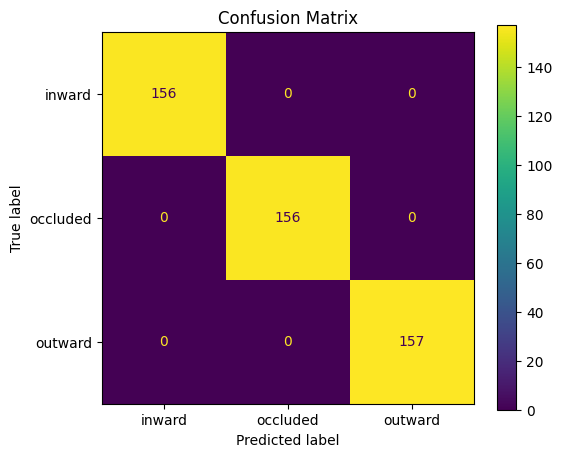

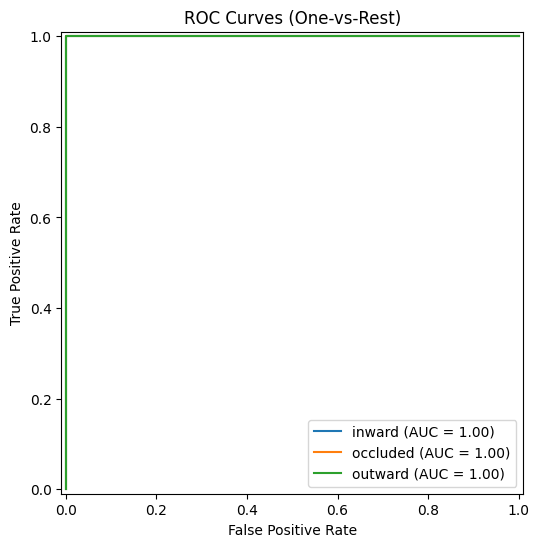

In [58]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import label_binarize
from torch.utils.data import DataLoader, TensorDataset

# Load best model
model.load_state_dict(torch.load("models/v2/v2_model.pt", map_location=device))
model.eval()

# DataLoader for test set
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64)

# Collect predictions
all_preds, all_probs, all_true = [], [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        out = model(Xb)
        probs = F.softmax(out, dim=1).cpu().numpy()
        preds = probs.argmax(axis=1)

        all_probs.extend(probs)
        all_preds.extend(preds)
        all_true.extend(yb.numpy())

all_probs = np.array(all_probs)
all_preds = np.array(all_preds)
all_true = np.array(all_true)

# Classification report
print("🔍 Classification Report:\n")
print(classification_report(all_true, all_preds, target_names=y_labels))

# Confusion matrix
cm = confusion_matrix(all_true, all_preds)
disp = RocCurveDisplay  # just to avoid unused import
from sklearn.metrics import ConfusionMatrixDisplay
fig_cm, ax_cm = plt.subplots(figsize=(6,5))
ConfusionMatrixDisplay(cm, display_labels=y_labels).plot(ax=ax_cm)
ax_cm.set_title("Confusion Matrix")
plt.show()

# ROC curves
y_bin = label_binarize(all_true, classes=range(len(y_labels)))
fpr, tpr, roc_auc = {}, {}, {}
fig_roc, ax_roc = plt.subplots(figsize=(8,6))

for i, label in enumerate(y_labels):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    RocCurveDisplay(fpr=fpr[i], tpr=tpr[i], roc_auc=roc_auc[i], estimator_name=label).plot(ax=ax_roc)

ax_roc.set_title("ROC Curves (One-vs-Rest)")
plt.show()
